#                                            test the multi-leader-multi-follower game to price the heterogenous electricity network

1. background information

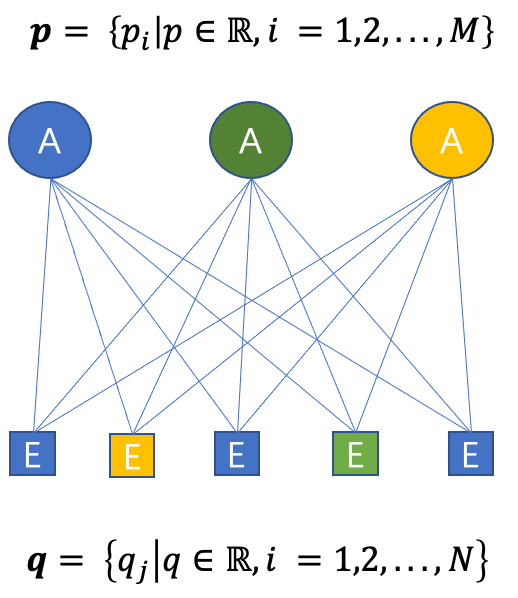

2. fomula construction

3. a new-form of ADMM method

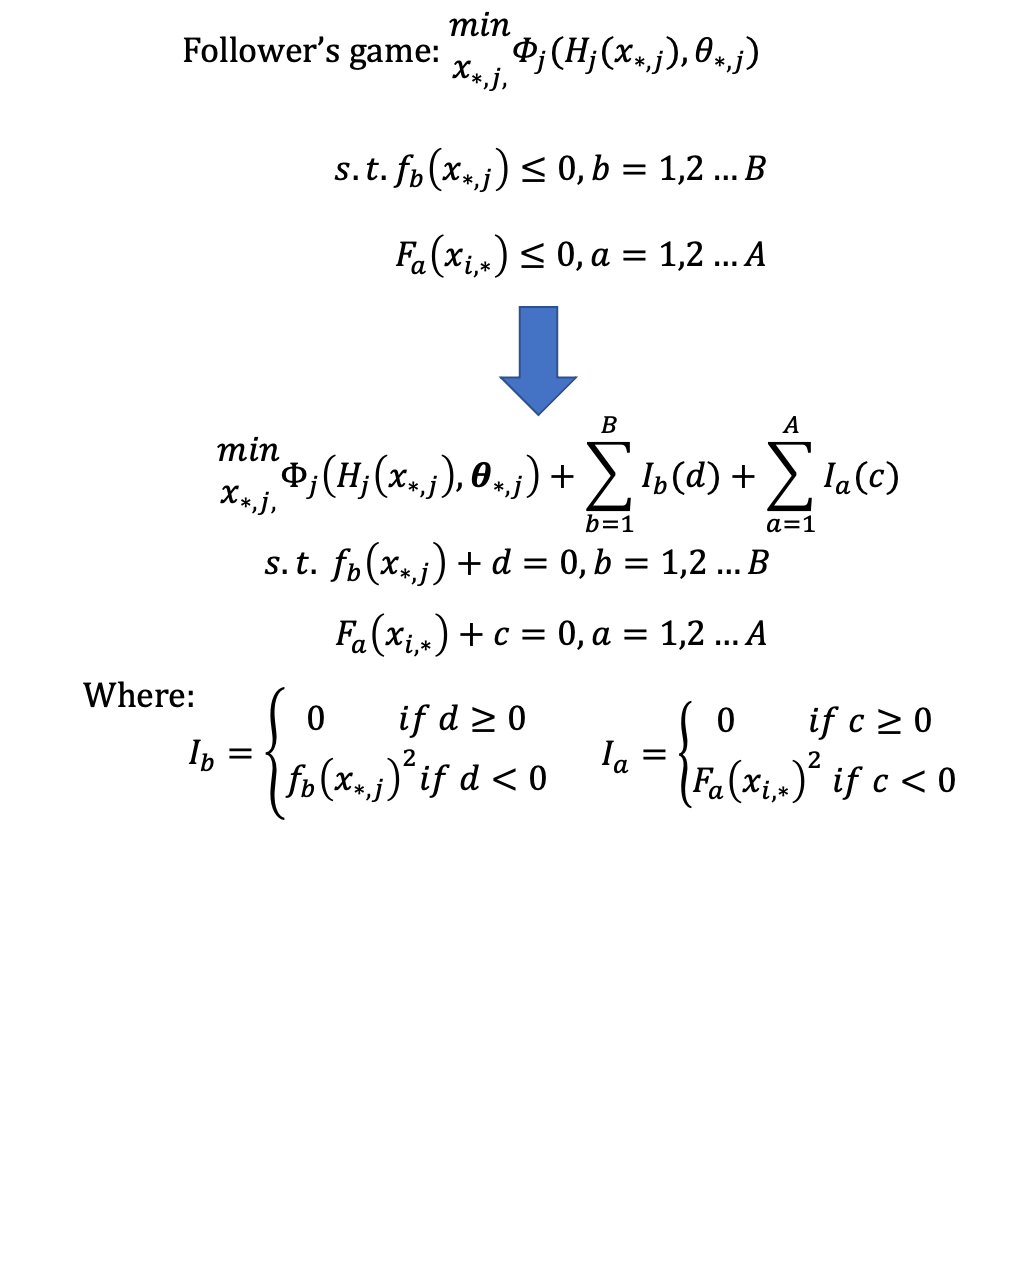

In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from numpy.linalg import inv
from numpy.linalg import norm
from joblib import Parallel, delayed
from multiprocessing import Process, Manager, cpu_count, Pool
from scipy.optimize import fsolve
from sympy import *
import seaborn as sns
%matplotlib inline

a real dataset with 68 EVs in a system

In [2]:
#prepare a random test day for 68—EVs
test_data = pd.read_csv('/Users/chengxiaoyuan/Desktop/academia/agile/dataset/EV_fleet.csv')
test_data[:5]

,ID,Node,Agent,Acorn_Group,X,Y,Phase,Feeder,Home_Battery_kW,Home_Battery_kWh,EV_Charger_Size_kW,EV_Battery_Size_kWh,PV_kW,Heat_Pump_Flag,smartmeter_ID,heatpump_ID,pv_ID,ev_ID
0,1,134,1,Affluent,372.0,155.437,1,1,5,13.5,7.0,33.0,1.0,1,28,5279,Bancroft Close,EN1306
1,2,147,1,Affluent,380.0,149.437,2,1,5,13.5,3.6,7.6,4.0,1,300,5429,Forest Road,EN1297
2,3,170,1,Affluent,368.0,159.437,1,1,5,13.5,3.6,7.6,3.0,1,351,5301,Maple Drive East,EN1913
3,4,173,1,Affluent,394.0,135.437,1,1,5,13.5,3.6,12.0,1.0,1,26,5415,Forest Road,EN1114
4,5,174,1,Affluent,394.0,135.437,1,1,5,13.5,7.0,60.0,2.0,1,304,5317,YMCA,EN1076


In [3]:
test_data = test_data[test_data['EV_Battery_Size_kWh']>0]
battery_size = np.array(test_data['EV_Charger_Size_kW'].values)

In [4]:
#randomly generating a electricity EV would like to trade in the market
def TradingElectricity(battery_size):
    return [random.randint(0,int(battery_size[i])) for i in range(len(battery_size))]

In [5]:
#generating an array for trading
test_trading_electricity = TradingElectricity(battery_size)
np.sum(test_trading_electricity)

165

In [6]:
np.array(test_trading_electricity).T

array([7, 1, 1, 3, 4, 0, 2, 3, 0, 1, 2, 2, 0, 7, 1, 5, 3, 5, 1, 2, 5, 0,
       3, 3, 0, 3, 7, 3, 1, 0, 3, 2, 3, 4, 2, 6, 0, 2, 0, 0, 2, 4, 0, 3,
       2, 1, 7, 0, 0, 4, 0, 7, 1, 2, 0, 3, 6, 2, 1, 0, 1, 0, 5, 3, 2, 2,
       4, 6])

In [12]:

arr_4am = [5, 2, 1, 3, 0, 2, 1, 2, 3, 1, 1, 6, 0, 4, 3, 6, 2, 7, 2, 2, 0, 0,
       3, 3, 3, 3, 5, 1, 2, 3, 2, 3, 0, 2, 2, 3, 2, 3, 1, 2, 2, 1, 6, 0,
       2, 3, 0, 2, 6, 0, 2, 1, 1, 1, 2, 0, 2, 2, 4, 2, 1, 2, 3, 7, 4, 1,
       5, 4]

arr_8am = [2, 2, 0, 3, 0, 0, 0, 2, 7, 1, 2, 4, 1, 4, 6, 4, 1, 1, 2, 1, 3, 1,
       3, 1, 2, 1, 5, 4, 5, 0, 0, 0, 2, 4, 5, 3, 2, 3, 1, 0, 0, 7, 2, 2,
       0, 7, 3, 0, 6, 4, 0, 7, 2, 0, 1, 1, 7, 3, 7, 0, 3, 0, 1, 5, 4, 7,
       2, 5]

arr_12am = [5, 2, 0, 2, 6, 1, 3, 3, 1, 2, 1, 7, 2, 5, 2, 1, 3, 6, 3, 5, 6, 3,
       5, 4, 1, 1, 5, 0, 2, 1, 1, 1, 1, 4, 4, 6, 1, 0, 2, 3, 0, 0, 5, 3,
       1, 5, 1, 1, 5, 6, 2, 2, 1, 1, 1, 0, 0, 3, 4, 1, 0, 3, 2, 3, 3, 5,
       4, 3]

arr_16am = [7, 1, 3, 2, 3, 2, 1, 1, 7, 1, 3, 7, 0, 4, 0, 6, 2, 3, 3, 6, 6, 1,
       0, 4, 0, 0, 3, 1, 3, 0, 1, 4, 3, 1, 2, 0, 0, 0, 2, 5, 2, 4, 1, 3,
       0, 2, 2, 1, 2, 0, 3, 5, 3, 3, 1, 1, 3, 2, 5, 1, 0, 0, 4, 6, 3, 0,
       0, 1]

arr_20am = [2, 3, 2, 3, 2, 1, 1, 2, 6, 1, 3, 0, 0, 4, 5, 3, 3, 3, 1, 6, 4, 1,
       7, 5, 1, 3, 7, 1, 4, 2, 3, 4, 2, 6, 4, 6, 0, 1, 3, 3, 1, 6, 5, 2,
       0, 3, 6, 0, 6, 7, 1, 6, 2, 7, 1, 1, 4, 0, 5, 1, 1, 0, 0, 3, 2, 3,
       4, 7]

arr_24am = [3, 2, 0, 0, 0, 2, 0, 3, 3, 2, 3, 3, 0, 4, 6, 3, 2, 1, 0, 3, 7, 0,
       7, 6, 1, 0, 1, 2, 7, 1, 3, 1, 3, 6, 6, 3, 1, 3, 2, 4, 0, 4, 3, 2,
       5, 0, 3, 0, 5, 0, 1, 4, 0, 3, 3, 2, 7, 3, 1, 3, 0, 2, 1, 2, 0, 5,
       4, 1]



In [ ]:
#look-up the electricity each EV would like to trade in aggregators
# test_trading_electricity[10]
np.sum(arr_16am)

156

In [ ]:
size = 68
x = np.arange(size)

total_width, n = , 68
width = total_width / n
x = x - (total_width - width) / 2

plt.bar(x, arr_8am,  width=width, label='a')
plt.bar(x + width, arr_12am, width=width, label='b')
plt.bar(x + 2 * width, arr_16am, width=width, label='c')
plt.bar(x + 3 * width, arr_20am, width=width, label='d')
plt.legend()
plt.show()

SyntaxError: invalid syntax (3458392810.py, line 4)

In [10]:
#define aggregator constraints
aggregator_constraint = [random.randint(40,160) for i in range(3)]
aggregator_constraint 

[146, 81, 128]

In [11]:
aggregator_constraint

[146, 81, 128]

# New-form of ADMM method

In [51]:
# the target solved matrix, a is the number of aggregator, x is the number of EVs
def MatrixSize(a,b):
    SolutionMatrix = np.random.rand(a,b)
    return SolutionMatrix

In [52]:
# define the function of aggregtors and EVs
# aggregator constraint
def PriceFunction(x,aggregator_constraint):
    x = np.sum(x)
    P = x/aggregator_constraint+aggregator_constraint/200
    return P
    
def AggregatorProfits(x,aggregator_constraint):
    z = np.sum(x)
    G = (z/aggregator_constraint+aggregator_constraint/1000)*z
    return G

# define the function of

In [53]:
#initialize dual variables
mu_i = MatrixSize(3,68)
mu_j = MatrixSize(3,68)
lam = MatrixSize(3,68)

mu_i_1 = 0
mu_j_1 = 0
lam_1 = 0

In [54]:
#A means the i-th row vector value
#B means the j-th column vector value
#a is EVs constraint
#b is aggregator's constraint
#last step parameter
#mu_i, mu_j and lam are dual variables 

def SolveSolution_X(A,B,a,b,mu_i,mu_j,lam,i,j,x_ij):
    x = symbols('x')
    A_i = np.sum(A)-A[j]
    A_ = np.sum(A)
    B_j = np.sum(B)-B[i]
    m = solve(2*x/b+A_i/b+b/200-1/(x+1)+(-1/(x_ij+1))
              -mu_i*np.sign(np.max([0,-x_ij]))+
              10*np.sign(np.max([0,-x_ij]))*(-2*x)+
              mu_j**np.sign(np.max([0,A_-b]))+
              10*np.sign(np.max([0,A_-b]))*(x+A_i-b)+
              lam+10*(x+B_j-a), x)
    m.append(0)
    return np.max(m)

def update_mu_i(mu_i,x):
    return mu_i+10*np.max([0,-x])

def update_mu_j(mu_j,x,b):
    return mu_j+10*np.max([0,np.sum(x)-b])

def update_lam(lam,x,a):
    return lam+10*np.max([0,np.sum(x)-a])
    
    

start to update
1 -the interation: the convergence:  131.64424475386016
2 -the interation: the convergence:  11.096983669844917
3 -the interation: the convergence:  7.073913642515862
4 -the interation: the convergence:  5.013212765319622
5 -the interation: the convergence:  3.3789653884188624
6 -the interation: the convergence:  2.324368170386066


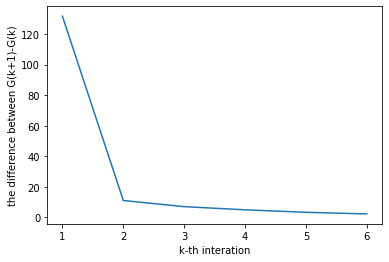

In [65]:
#initialize solution A, three aggregators amd 68 EVs
Initialized_A = MatrixSize(3,68)

Solution_A = Initialized_A

k = 0 

# C means column and R means row
C = Initialized_A.shape[1]
R = Initialized_A.shape[0]

#define the aggregator constraints
aggregator_constraint = aggregator_constraint

#input the trading electricity
test_trading_electricity = arr_20am

#initalize the profits of aggregators
profits_vector = [AggregatorProfits(Initialized_A[i],aggregator_constraint[i]) 
                   for i in range(len(aggregator_constraint))]

#define G(k) and G(k-1)
G_k = np.sum(profits_vector)
G_k_1 = 0

#penality coefficiency 
ru = 30

step_length = []
step = []

print("start to update")

while abs(G_k-G_k_1)>=3:
    
    #solve followers game, J 
    for j in range(C):
        for i in range(R): # the number of i-th aggregator, heterougenous system
            Solution_A[i][j]= SolveSolution_X(Solution_A[i],
                                              Solution_A.T[j],test_trading_electricity[j],
                                              aggregator_constraint[i],
                                              mu_i[i][j],mu_j[i,j],lam[i,j],i,j,Solution_A[i][j])
            
            mu_i[i][j] = update_mu_i(mu_i[i][j],Solution_A[i][j])
            mu_j[i][j] = update_mu_j(mu_j[i][j],Solution_A[i],aggregator_constraint[i])
            lam[i][j] = update_lam(lam[i][j],Solution_A.T[j],test_trading_electricity[j])
    
    
    G_k_1 = G_k
    
    G_k = np.sum([AggregatorProfits(Solution_A[i],aggregator_constraint[i]) 
                   for i in range(len(aggregator_constraint))])
    
    k = k+1
    step.append(k)
    step_length.append(abs(G_k-G_k_1))
    
    print(k, "-the interation: the convergence: ", abs(G_k-G_k_1))
            
fig = plt.plot(step,step_length)
plt.ylabel('the difference between G(k+1)-G(k)')
plt.xlabel('k-th interation')
plt.show()

In [62]:
np.save('/Users/chengxiaoyuan/Desktop/academia/agile/dataset/trading_matrix.npy', Solution_A)

In [56]:
np.array(test_trading_electricity).T

array([5, 2, 0, 2, 6, 1, 3, 3, 1, 2, 1, 7, 2, 5, 2, 1, 3, 6, 3, 5, 6, 3,
       5, 4, 1, 1, 5, 0, 2, 1, 1, 1, 1, 4, 4, 6, 1, 0, 2, 3, 0, 0, 5, 3,
       1, 5, 1, 1, 5, 6, 2, 2, 1, 1, 1, 0, 0, 3, 4, 1, 0, 3, 2, 3, 3, 5,
       4, 3])

In [64]:
Solution_A.T[1]

array([1.6180517 , 0.97780088, 0.35052942])

In [80]:
PriceFunction(np.sum(Solution_A[1]),105)*10

10.883868105378657

In [58]:
print(np.sum(test_trading_electricity))

176


In [61]:
print( np.sum(Solution_A))

169.7669394048426


In [ ]:
(np.sum(Solution_A,axis=0)).shape

(57,)

In [66]:
Solution_A_58 = np.array(Solution_A.T[0:57])
SolutionTable = pd.DataFrame(Solution_A_58.T)

In [67]:
SolutionTable.columns = [i for i in range(0,57)]
SolutionTable.rename(index={0:'Aggregator 1',1:'Aggregator 2',2:'Aggregator 3'},inplace=True)
 

In [68]:
SolutionTable.to_csv('/Users/chengxiaoyuan/Desktop/data_8_pm.csv')

In [68]:
a[0:2]

NameError: name 'a' is not defined

<AxesSubplot:>

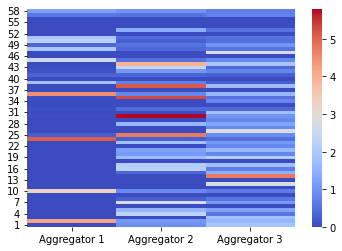

In [67]:
sns.heatmap(SolutionTable.T, cmap='coolwarm')

In [77]:
flight = sns.load_dataset('flights') # load flights datset from GitHub seaborn repository

# reshape flights dataeset in proper format to create seaborn heatmap
flights_df = flight.pivot('month', 'year', 'passengers') 

In [78]:
flight_df

year,1949,1950,1951,1952,1953,1954,1955,1956,1957,1958,1959,1960
month,,,,,,,,,,,,
Jan,112,115,145,171,196,204,242,284,315,340,360,417
Feb,118,126,150,180,196,188,233,277,301,318,342,391
Mar,132,141,178,193,236,235,267,317,356,362,406,419
Apr,129,135,163,181,235,227,269,313,348,348,396,461
May,121,125,172,183,229,234,270,318,355,363,420,472
Jun,135,149,178,218,243,264,315,374,422,435,472,535
Jul,148,170,199,230,264,302,364,413,465,491,548,622
Aug,148,170,199,242,272,293,347,405,467,505,559,606
Sep,136,158,184,209,237,259,312,355,404,404,463,508


In [76]:
flight_df()

TypeError: 'DataFrame' object is not callable